# Running Specialized Agents in Parallel with the OpenAI Agents SDK

Why would you want to do this?
In many production workflows you must answer several independent questions about the same piece of content.
Doing those analyses one-by-one increases latency and can increase total cost if any step fails and forces a retry.
By "fanning out" multiple specialized agents at the same time and then "fanning in" their outputs to a final “meta” agent, you're able to reduce this latency.

This notebook present a toy example that you likely wouldn't parallelize in the real world, but that shows:
1. How to define several focused agents with the OpenAI Agents SDK.
2. How to execute them concurrently using either Python [asyncio](https://docs.python.org/3/library/asyncio.html) for lower latency, lightweight parallelization or directly through the [Agents SDK](https://openai.github.io/openai-agents-python/tools/#agents-as-tools) for ease of management and dynamic tool call planning.
3. How to gather their individual outputs and feed them into a downstream meta-agent that produces the final, user-ready answer.
4. A simple timeline visualization so you can see the latency benefit of parallelization.

This same pattern can be adapted to real world scenarios such as customer-support triage, content moderation, or other scenarios where you might want to run multiple independent analyses on an input and merge them into a single outcome.

1. Install dependencies

In [ ]:
%pip install openai-agents asyncio matplotlib nest_asyncio

import time

import asyncio
import matplotlib.pyplot as plt
import nest_asyncio

from agents import Agent, Runner

nest_asyncio.apply()

2. Define your Agents

In [2]:
# Agent focusing on product features
features_agent = Agent(
    name="FeaturesAgent",
    instructions="Extract the key product features from the review."
)

# Agent focusing on pros & cons
pros_cons_agent = Agent(
    name="ProsConsAgent",
    instructions="List the pros and cons mentioned in the review."
)

# Agent focusing on sentiment analysis
sentiment_agent = Agent(
    name="SentimentAgent",
    instructions="Summarize the overall user sentiment from the review."
)

# Agent focusing on recommendation summary
recommend_agent = Agent(
    name="RecommendAgent",
    instructions="State whether you would recommend this product and why."
)

parallel_agents = [
    features_agent,
    pros_cons_agent,
    sentiment_agent,
    recommend_agent
]

# Meta-agent to combine outputs
meta_agent = Agent(
    name="MetaAgent",
    instructions="You are given multiple summaries labeled with Features, ProsCons, Sentiment, and a Recommendation."
    " Combine them into a concise executive summary of the product review with a 1-5 star rating for each summary area."
)


In [3]:
starts, ends = [], []
async def run_agent(agent, review_text: str):
    agent_name = agent.name

    start = time.time()
    starts.append((agent_name, start))

    result = await Runner.run(agent, review_text)

    end = time.time()
    ends.append((agent_name, end))

    return result

3. Create function for parallel execution

In [4]:
async def run_agents(review_text: str):
    responses = await asyncio.gather(
        *(run_agent(agent, review_text) for agent in parallel_agents)
    )

    labeled_summaries = [
        f"### {resp.last_agent.name}\n{resp.final_output}"
        for resp in responses
    ]

    collected_summaries = "\n".join(labeled_summaries)
    final_summary = await run_agent(meta_agent, collected_summaries)


    print('Final summary:', final_summary.final_output)

    return

Final summary: ### Executive Summary

The AuroraSound X2 wireless noise-cancelling headphones offer a blend of premium design and advanced features. The headphones boast a matte-finish with comfortable, memory-foam padding, making them ideal for extended use. With Bluetooth 5.2, they provide seamless connectivity and stable communication. The noise-cancelling capabilities effectively reduce ambient noise and feature a well-tuned Transparency mode for essential sound transmission.

**Audio Quality** is a highlight, delivering rich, balanced sound with customizable EQ presets including “Podcast,” “Bass Boost,” and “Concert Hall.” Intuitive touch controls allow for easy navigation, though some users report occasional misfires. The extended battery life offers over 30 hours with ANC on, with a quick-charge option for convenience.

**Minor Limitations** include a bulky carrying case, occasional touch control issues, and limited color choices (black or white). Despite these, the overall sent

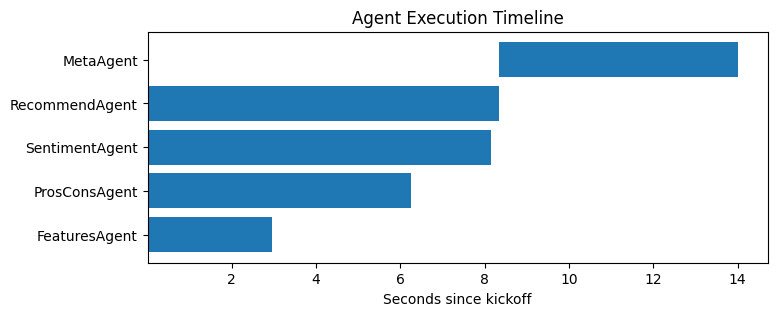

In [5]:
review_text = """
I recently upgraded to the AuroraSound X2 wireless noise-cancelling headphones, and after two weeks of daily use I have quite a bit to share. First off, the design feels premium without being flashy: the matte‐finish ear cups are softly padded and rotate smoothly for storage, while the headband’s memory‐foam cushion barely presses on my temples even after marathon work calls. Connectivity is seamless—pairing with my laptop and phone took under five seconds each time, and the Bluetooth 5.2 link held rock-solid through walls and down the hallway.

The noise-cancelling performance is genuinely impressive. In a busy café with music and chatter swirling around, flipping on ANC immediately quiets low-level ambient hums, and it even attenuates sudden noises—like the barista’s milk frother—without sounding distorted. The “Transparency” mode is equally well‐tuned: voices come through clearly, but the world outside isn’t overwhelmingly loud. Audio quality in standard mode is rich and balanced, with tight bass, clear mids, and a hint of sparkle in the highs. There’s also a dedicated EQ app, where you can toggle between “Podcast,” “Bass Boost,” and “Concert Hall” presets or craft your own curve.

On the control front, intuitive touch panels let you play/pause, skip tracks, and adjust volume with a simple swipe or tap. One neat trick: holding down on the right ear cup invokes your phone’s voice assistant. Battery life lives up to the hype, too—over 30 hours with ANC on, and the quick‐charge feature delivers 2 hours of playtime from just a 10-minute top-up.

That said, it isn’t perfect. For one, the carrying case is a bit bulky, so it doesn’t slip easily into a slim bag. And while the touch interface is mostly reliable, I occasionally trigger a pause when trying to adjust the cup position. The headphones also come in only two colorways—black or white—which feels limiting given the premium price point.
"""

asyncio.get_event_loop().run_until_complete(run_agents(review_text))

def plot_timeline(starts, ends):

    # Plot the timeline of the agents
    # normalize times to zero
    base = min(t for _, t in starts)
    labels = [n for n, _ in starts]
    start_offsets = [t - base for _, t in starts]
    lengths = [ends[i][1] - starts[i][1] for i in range(len(starts))]

    plt.figure(figsize=(8, 3))
    plt.barh(labels, lengths, left=start_offsets)
    plt.xlabel("Seconds since kickoff")
    plt.title("Agent Execution Timeline")
    plt.show()

plot_timeline(starts, ends)

The agents can also be parallelized directly through the SDK via the "agent as tool" route, adding convenience and the assistance of the planner dynamically deciding which tools to call at the expense of higher latency. This latency comes both from the additional planning API call up front, along with the higher overhead and context from the tool call objects.

Final summary: **Executive Summary: AuroraSound X2 Wireless Noise-Cancelling Headphones**

**Features (⭐️⭐️⭐️⭐️⭐️ 5/5):** The headphones boast a premium, matte-finish design with comfortable memory-foam cushioning. They offer seamless Bluetooth 5.2 connectivity, impressive noise-cancelling capabilities, and a well-tuned "Transparency" mode. The audio quality is rich and balanced, with customizable sound options via a dedicated EQ app. Additional features include intuitive touch controls and excellent battery life paired with a quick-charge option.

**Pros and Cons (⭐️⭐️⭐️⭐️ 4/5):** 
- **Pros:** Premium design, comfortable fit, seamless connectivity, effective noise-cancelling, clear voice input in "Transparency" mode, customizable audio, intuitive controls, long battery life.
- **Cons:** Bulky carrying case, occasional touch control sensitivity issues, limited color options.

**Sentiment (⭐️⭐️⭐️⭐️ 4/5):** The overall sentiment is highly positive, with appreciation for the design, comfo

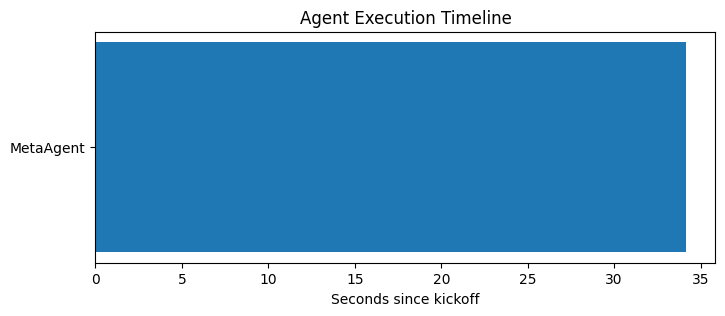

In [7]:
from agents import ModelSettings


meta_agent_parallel_tools = Agent(
    name="MetaAgent",
    instructions="You are given multiple summaries labeled with Features, ProsCons, Sentiment, and a Recommendation."
    " Combine them into a concise executive summary of the product review with a 1-5 star rating for each summary area.",
   model_settings=ModelSettings(
       parallel_tool_calls=True
   ),
    tools=[
        features_agent.as_tool(
            tool_name="features",
            tool_description="Extract the key product features from the review.",
        ),
        pros_cons_agent.as_tool(
            tool_name="pros_cons",
            tool_description="List the pros and cons mentioned in the review.",
        ),
        sentiment_agent.as_tool(
            tool_name="sentiment",
            tool_description="Summarize the overall user sentiment from the review.",
        ),
        recommend_agent.as_tool(
            tool_name="recommend",
            tool_description="State whether you would recommend this product and why.",
        ),
    ],
)

starts, ends = [], []
result = await run_agent(meta_agent_parallel_tools, review_text)

print('Final summary:', result.final_output)

plot_timeline(starts, ends)


## Summary

From the above, we can see two different patterns for parallelizing agents. Ultimately, the approach you use will depend on the balance you want between:

1. Convenience vs. customization
    * If you prefer convenience, the agent as tool route is the way to go. If you want to customize how agents fan in and out across multiple layers, building a graph with `asyncio.gather` might make more sense
1. Planning vs. determinism
    * If you want your planner (in this case the meta agent) to dynamically decide which tools to call and the order, you should use agents as tools whereas `asyncio.gather` makes more sense if you want a deterministic order.
1. Latency sensitivity
    * If you're highly sensitive to latency, you may want to use `asyncio` to avoid the additional upfront cost of planning the parallel tools and the overhead of tool outputs and longer context windows.